# 1.27c: Thimble 3 Lattice Hopping Analysis

**Purpose:** Characterize the frozen/hopping/thermal regimes by analyzing displacement magnitudes relative to bfloat16 quantization.

## Theory

In bfloat16, each component of a token vector lives on a discrete lattice with spacing = ULP (unit in the last place). A token in a 64D hypercube can:

1. **Stay frozen**: displacement = 0 (bitwise identical)
2. **Lattice hop**: move along edges/diagonals of the quantization hypercube
   - Single-axis hop: displacement ≈ ULP
   - Diagonal hop: displacement ≈ √64 × ULP = 8 × ULP (corner to opposite corner)
3. **Thermal motion**: displacement > 8 × ULP (continuous, not quantization-limited)

We'll classify tokens at each timestep and track the phase transition from thermal → lattice → frozen.

## ULP Calculation

For bfloat16, ULP(x) = nextafter(x, +∞) - x

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Thimble/thimble_3.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Classification thresholds
DIAGONAL_FACTOR = 8  # sqrt(64) for hypercube diagonal

# Analysis windows
LATE_WINDOW_START = 800  # Start of "late training" window

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Thimble 3 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix (keep as bfloat16 for ULP calculation, but also get float32 version)
W_bf16 = data['W']  # (1001, 10000, 64) in bfloat16
W = W_bf16.float()  # (1001, 10000, 64) in float32 for arithmetic

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"W dtype (original): {W_bf16.dtype}")
print(f"W dtype (working): {W.dtype}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Thimble 3 data...



W shape: (1001, 10000, 64)
W dtype (original): torch.bfloat16
W dtype (working): torch.float32
Dead tokens: 3699

✓ Data loaded


## Compute ULP Matrix

In [5]:
def compute_ulp_matrix(W_bf16):
    """
    Compute ULP for each element of W using nextafter.
    
    Args:
        W_bf16: Tensor in bfloat16 format
    
    Returns:
        ULP matrix (same shape as W_bf16) in float32
    """
    # Compute nextafter(x, +inf) - x for each element
    inf_tensor = torch.tensor(float('inf'), dtype=torch.bfloat16, device=W_bf16.device)
    next_up = torch.nextafter(W_bf16, inf_tensor)
    ulp = (next_up - W_bf16).abs().float()
    return ulp

print("Computing ULP matrix for all timesteps...\n")

# Extract dead tokens only
W_bf16_dead = W_bf16[:, dead_mask, :]  # (1001, n_dead, 64)
W_dead = W[:, dead_mask, :]  # (1001, n_dead, 64)

# Compute ULP for all dead tokens at all timesteps
# Note: We'll compute this on-demand per timestep to save memory
print("Computing ULP per-timestep (on-demand to save memory)")
print(f"\n✓ ULP computation ready")

Computing ULP matrix for all timesteps...



Computing ULP per-timestep (on-demand to save memory)

✓ ULP computation ready


## Classify Token Motion

In [6]:
print("Classifying token motion at each timestep...\n")

n_steps = W_dead.shape[0] - 1  # 1000 steps (t=0 to t=1000)
n_dead = W_dead.shape[1]

# Preallocate classification arrays
fraction_frozen = torch.zeros(n_steps)
fraction_lattice = torch.zeros(n_steps)
fraction_thermal = torch.zeros(n_steps)

# Track displacement statistics
mean_displacement = torch.zeros(n_steps)
mean_ulp = torch.zeros(n_steps)

# Classify each timestep
for t in range(n_steps):
    # Displacement from t to t+1
    dW = W_dead[t+1] - W_dead[t]  # (n_dead, 64)
    displacement_norms = torch.norm(dW, dim=1)  # (n_dead,)
    
    # ULP at time t
    ulp_matrix = compute_ulp_matrix(W_bf16_dead[t])  # (n_dead, 64)
    mean_ulp_per_token = ulp_matrix.mean(dim=1)  # (n_dead,)
    
    # Thresholds
    lattice_threshold = DIAGONAL_FACTOR * mean_ulp_per_token  # (n_dead,)
    
    # Classify
    frozen = (displacement_norms == 0)
    lattice = (displacement_norms > 0) & (displacement_norms <= lattice_threshold)
    thermal = (displacement_norms > lattice_threshold)
    
    # Store fractions
    fraction_frozen[t] = frozen.float().mean()
    fraction_lattice[t] = lattice.float().mean()
    fraction_thermal[t] = thermal.float().mean()
    
    # Store statistics
    mean_displacement[t] = displacement_norms.mean()
    mean_ulp[t] = mean_ulp_per_token.mean()
    
    if t % 200 == 0:
        print(f"t={t}: {fraction_frozen[t]:.1%} frozen, {fraction_lattice[t]:.1%} lattice, {fraction_thermal[t]:.1%} thermal")

print(f"\n✓ Classification complete")

Classifying token motion at each timestep...

t=0: 0.0% frozen, 0.0% lattice, 100.0% thermal
t=200: 0.0% frozen, 100.0% lattice, 0.0% thermal
t=400: 2.8% frozen, 97.2% lattice, 0.0% thermal


t=600: 90.3% frozen, 9.7% lattice, 0.0% thermal
t=800: 81.3% frozen, 18.7% lattice, 0.0% thermal

✓ Classification complete


## Plot: Fraction in Each Regime Over Time

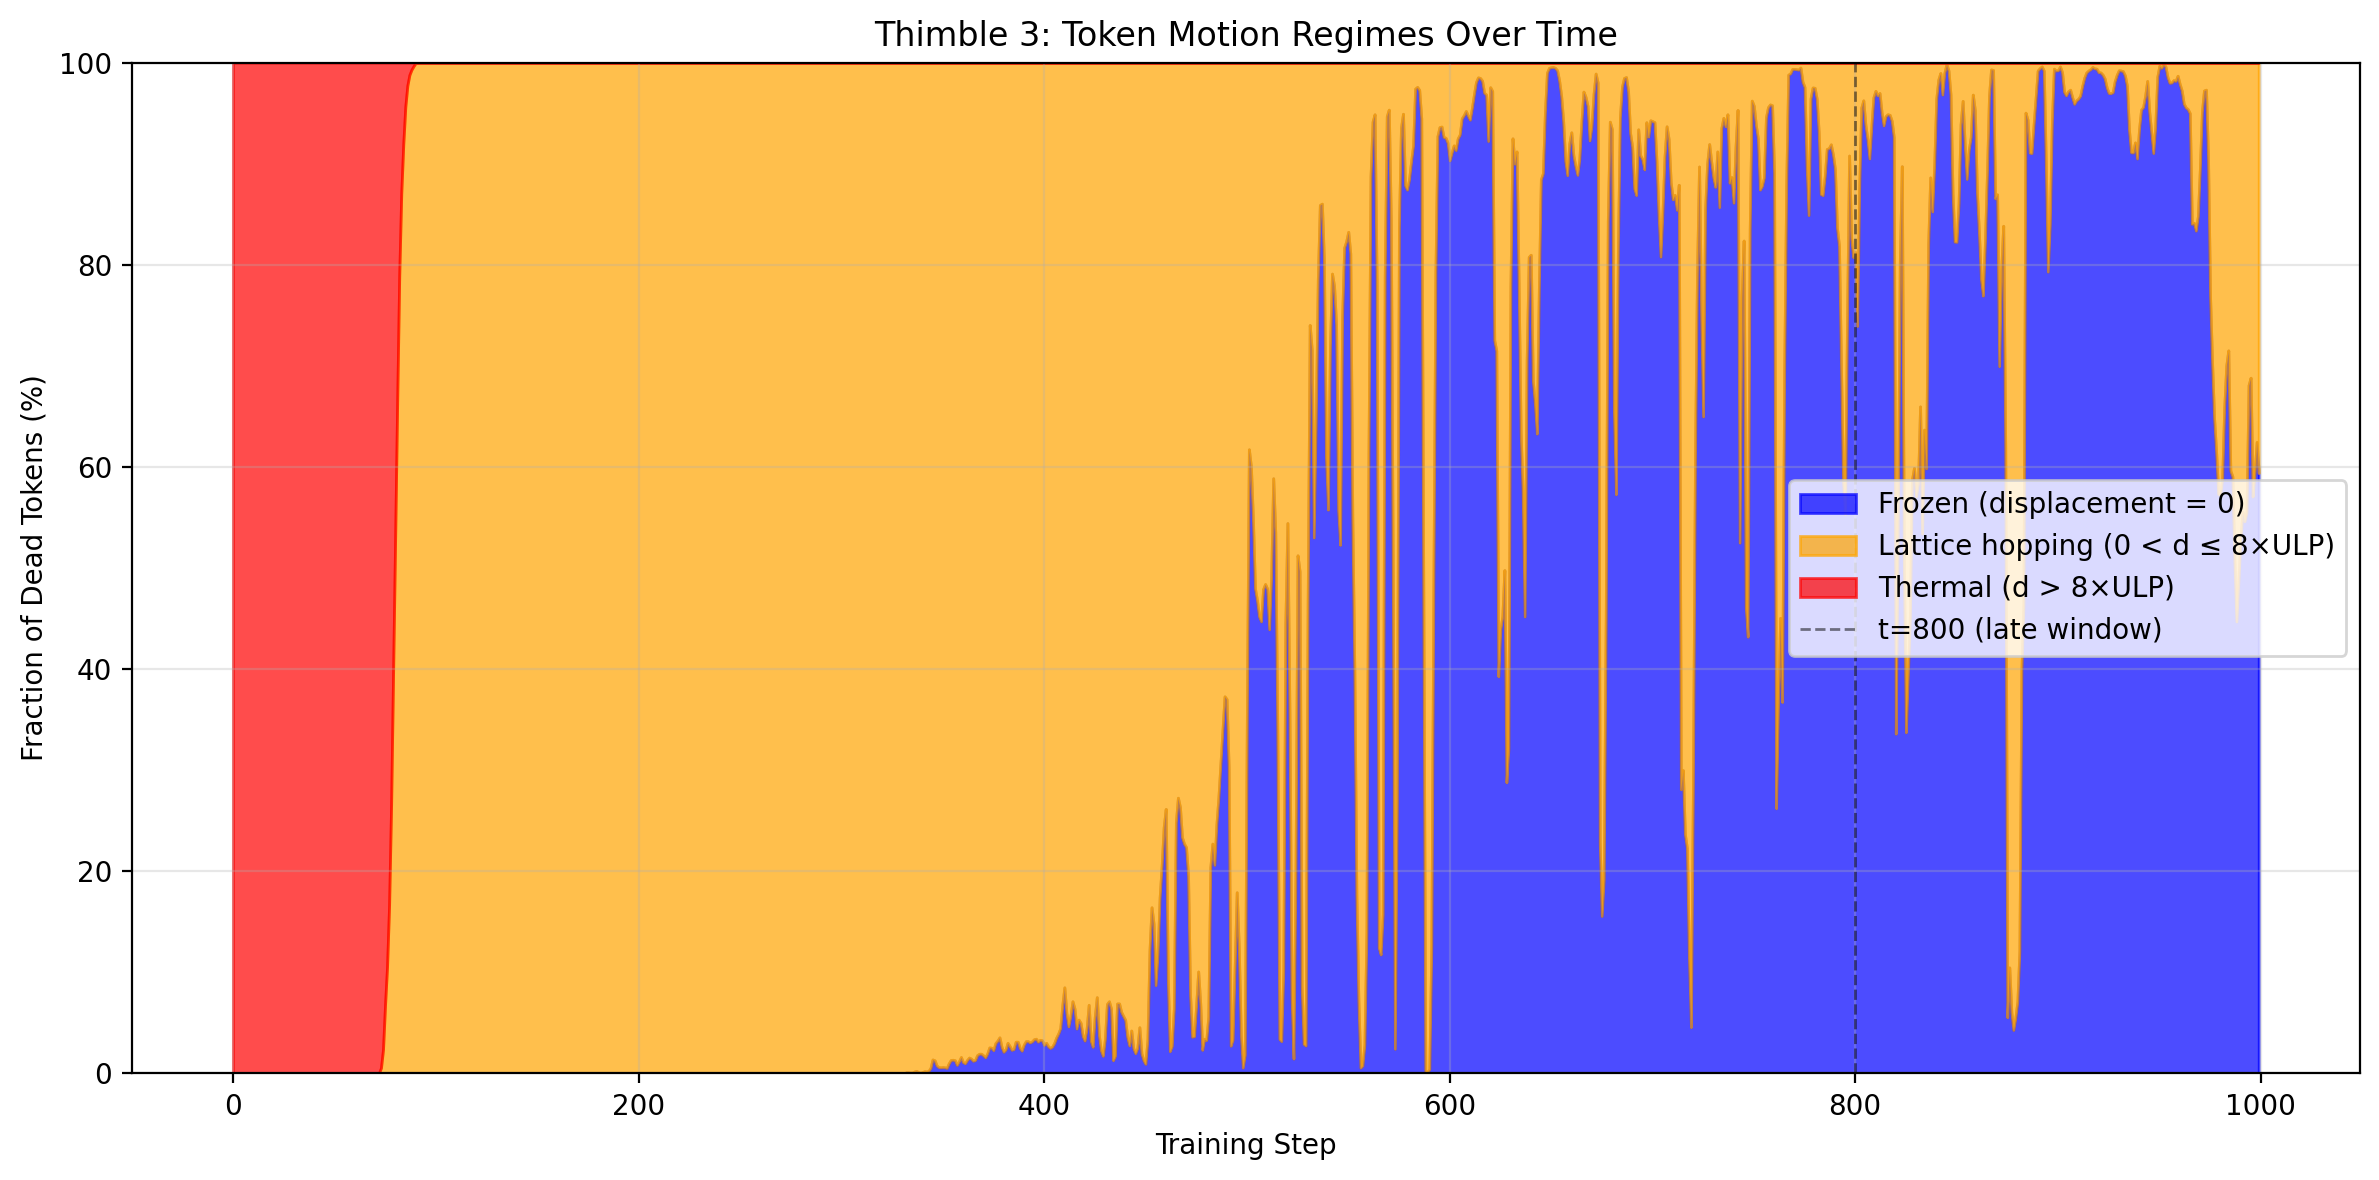

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stacked area plot
ax.fill_between(range(n_steps), 0, fraction_frozen.numpy()*100, 
                color='blue', alpha=0.7, label='Frozen (displacement = 0)')
ax.fill_between(range(n_steps), fraction_frozen.numpy()*100, 
                (fraction_frozen + fraction_lattice).numpy()*100, 
                color='orange', alpha=0.7, label='Lattice hopping (0 < d ≤ 8×ULP)')
ax.fill_between(range(n_steps), (fraction_frozen + fraction_lattice).numpy()*100, 100,
                color='red', alpha=0.7, label='Thermal (d > 8×ULP)')

ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5, label=f't={LATE_WINDOW_START} (late window)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens (%)')
ax.set_title('Thimble 3: Token Motion Regimes Over Time')
ax.legend(loc='right')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Plot: Mean Displacement vs. Mean ULP

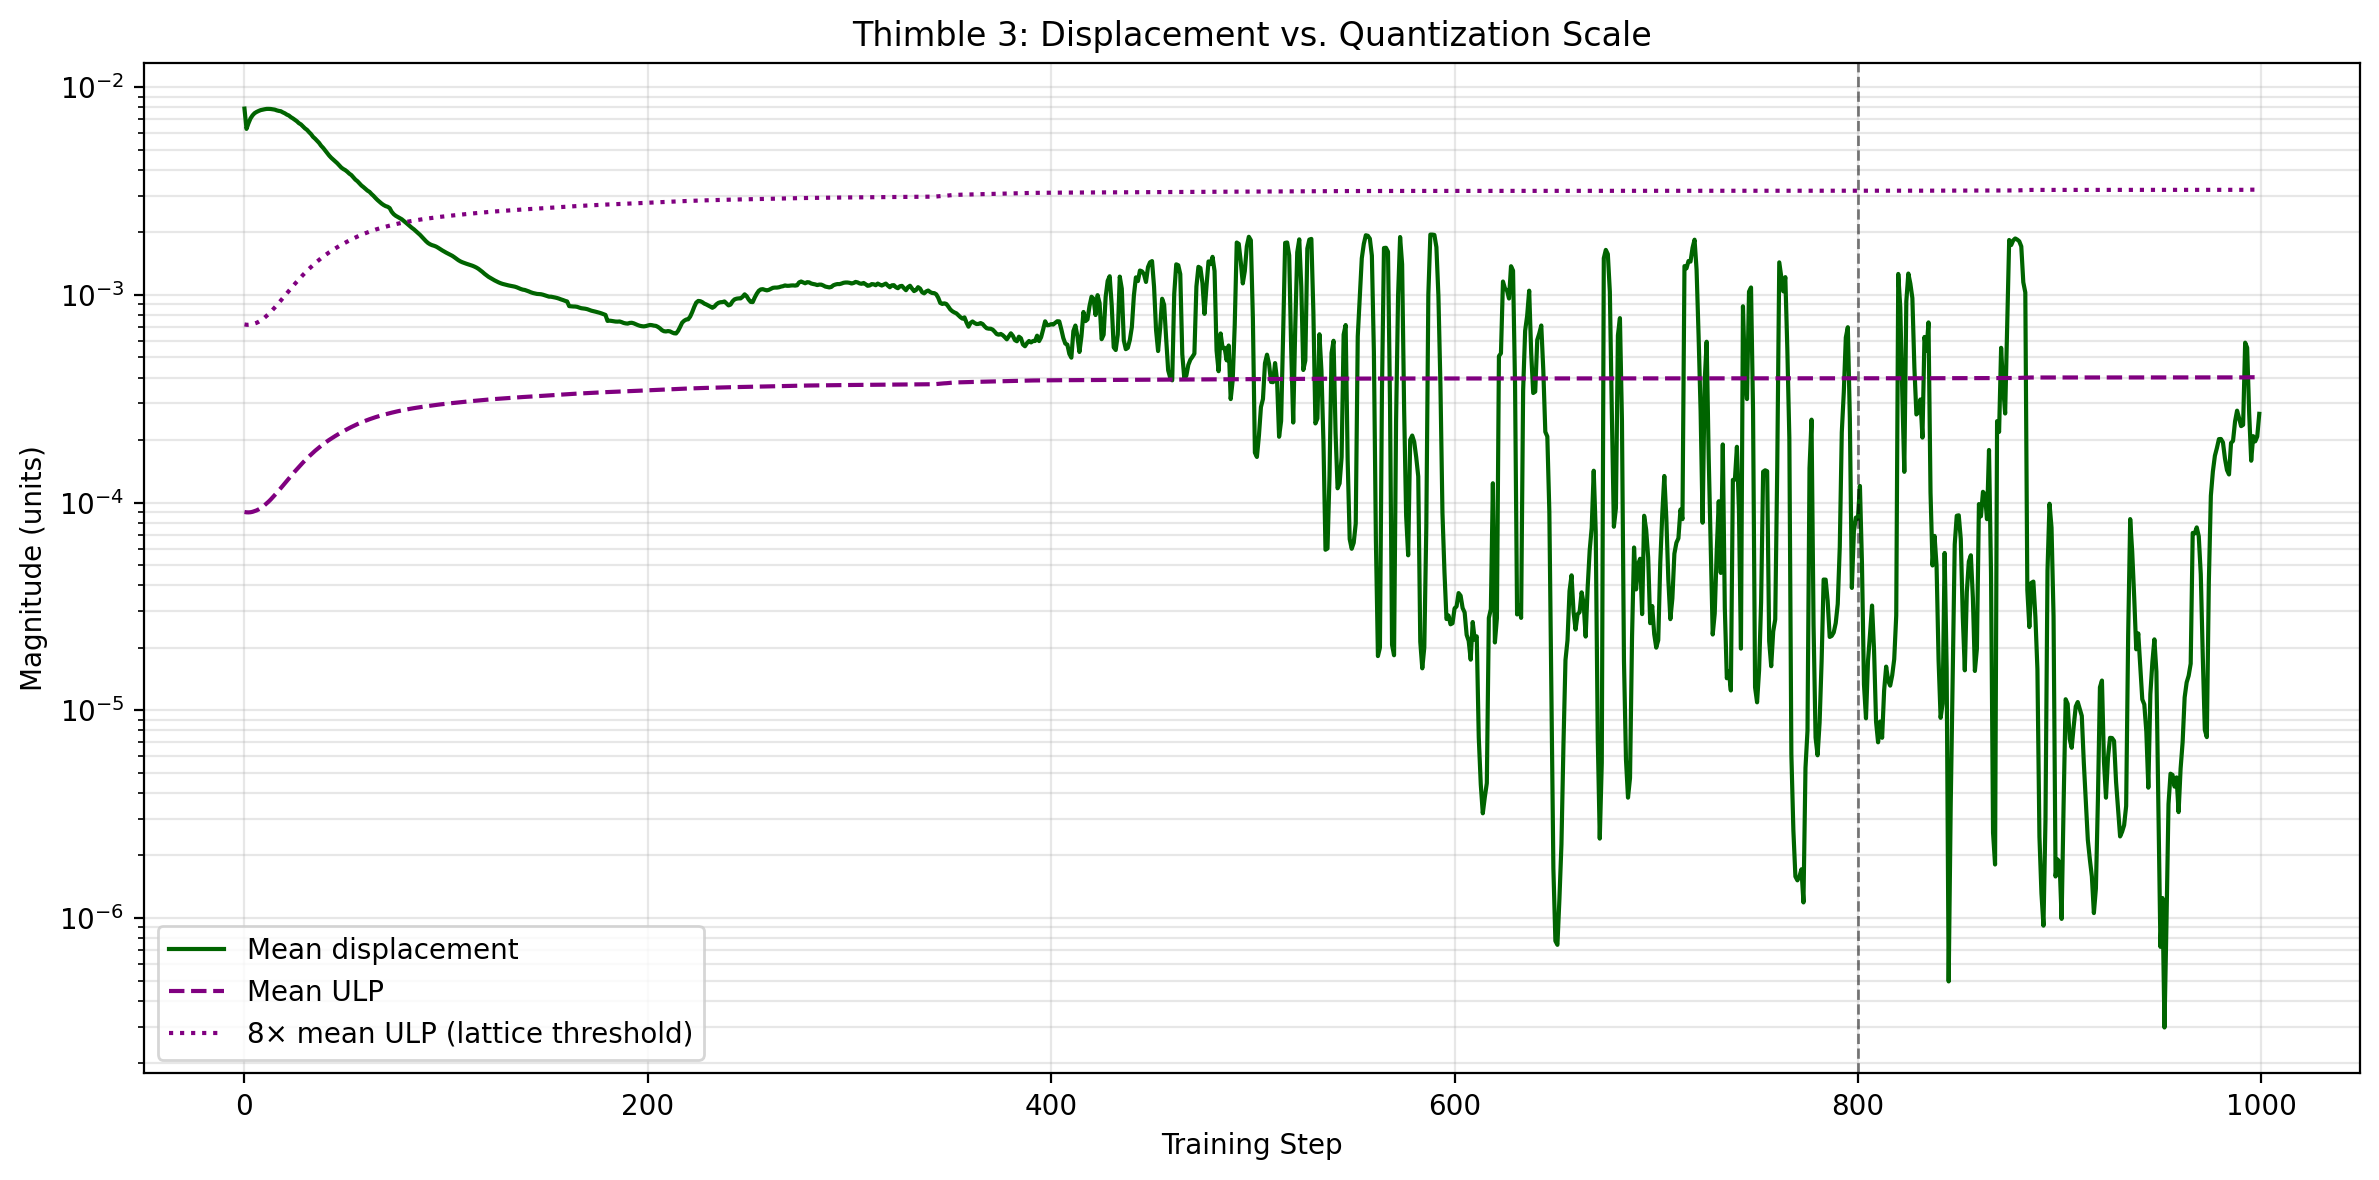

Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.


In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_displacement.numpy(), linewidth=1.5, color='darkgreen', label='Mean displacement')
ax.plot(mean_ulp.numpy(), linewidth=1.5, color='purple', label='Mean ULP', linestyle='--')
ax.plot((DIAGONAL_FACTOR * mean_ulp).numpy(), linewidth=1.5, color='purple', 
        label=f'{DIAGONAL_FACTOR}× mean ULP (lattice threshold)', linestyle=':')

ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Magnitude (units)')
ax.set_title('Thimble 3: Displacement vs. Quantization Scale')
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.")

## Late Training Analysis (t=800–1000)

In [9]:
print("="*80)
print(f"LATE TRAINING ANALYSIS (t={LATE_WINDOW_START}–{n_steps})")
print("="*80 + "\n")

late_window = slice(LATE_WINDOW_START, n_steps)

# Average fractions in late window
late_frozen = fraction_frozen[late_window].mean()
late_lattice = fraction_lattice[late_window].mean()
late_thermal = fraction_thermal[late_window].mean()

print(f"Average fractions:")
print(f"  Frozen:  {late_frozen:.1%}")
print(f"  Lattice: {late_lattice:.1%}")
print(f"  Thermal: {late_thermal:.1%}")
print()

# Trend: is frozen fraction still increasing?
frozen_start = fraction_frozen[LATE_WINDOW_START]
frozen_end = fraction_frozen[-1]
frozen_change = frozen_end - frozen_start

print(f"Frozen fraction trend:")
print(f"  At t={LATE_WINDOW_START}: {frozen_start:.1%}")
print(f"  At t={n_steps}: {frozen_end:.1%}")
print(f"  Change: {frozen_change:+.1%}")
print()

if frozen_change > 0.01:  # More than 1% increase
    print("✓ Cloud is still freezing (frozen fraction increasing)")
elif frozen_change < -0.01:
    print("✓ Cloud is thawing (frozen fraction decreasing)")
else:
    print("✓ Cloud is at equilibrium (frozen fraction stable)")

print("\n" + "="*80 + "\n")

LATE TRAINING ANALYSIS (t=800–1000)

Average fractions:
  Frozen:  83.0%
  Lattice: 17.0%
  Thermal: 0.0%

Frozen fraction trend:
  At t=800: 81.3%
  At t=1000: 59.4%
  Change: -21.9%

✓ Cloud is thawing (frozen fraction decreasing)




## Displacement Distribution Histograms

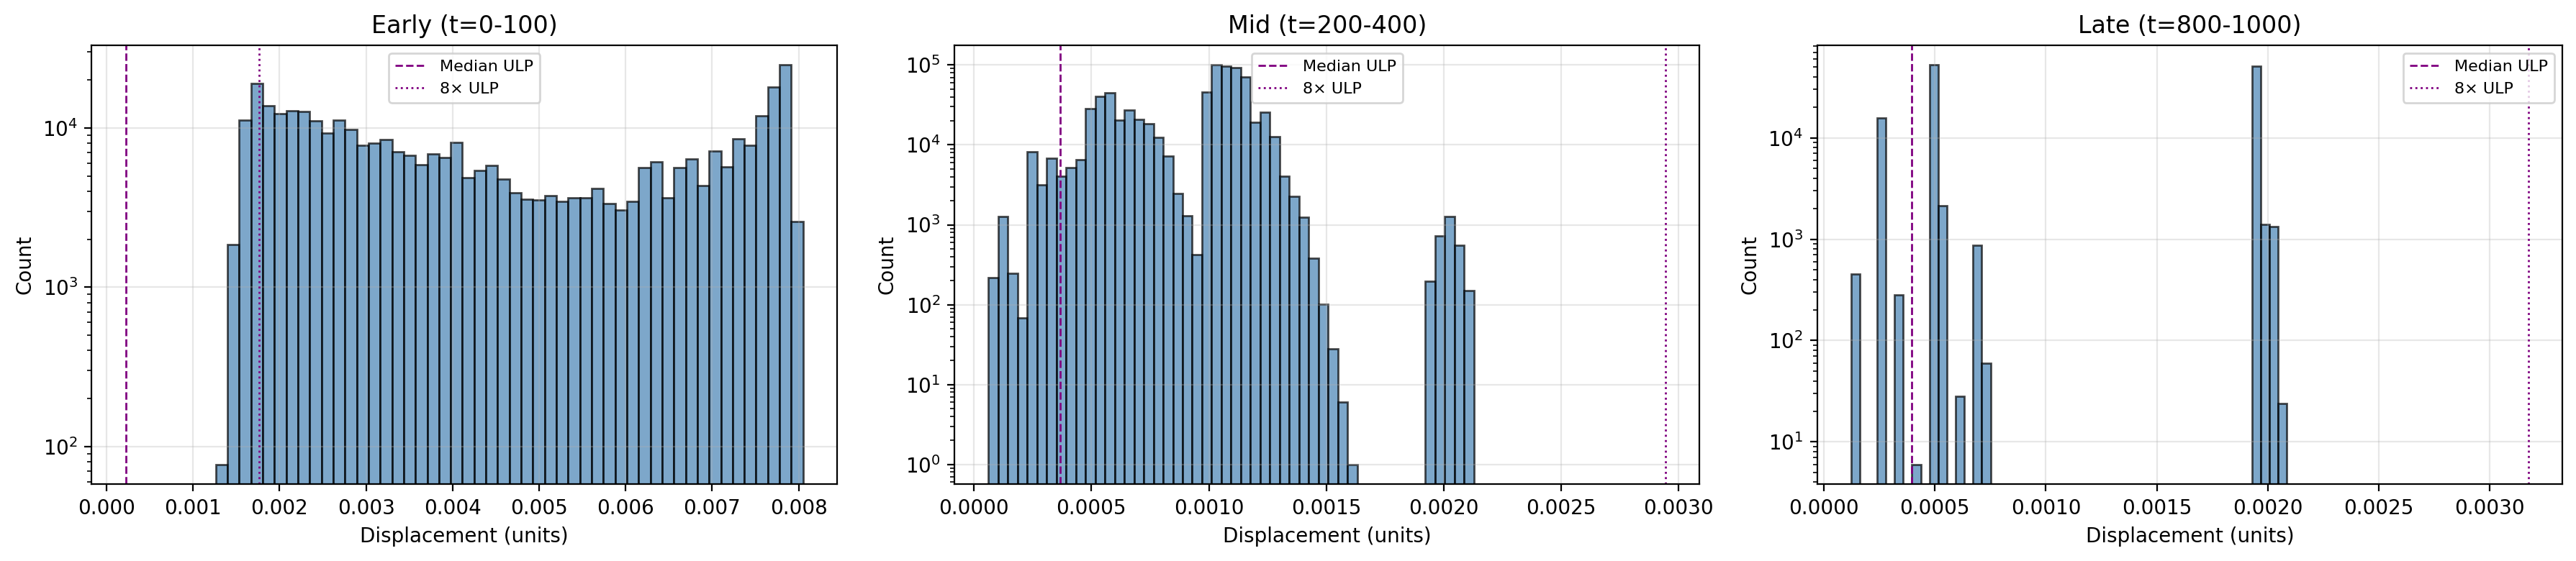

Interpretation: Look for peak shifting from >> ULP (thermal) to ≈ ULP (lattice) to none (frozen).


In [10]:
# Compare displacement distributions in different epochs
epochs = [
    ("Early (t=0-100)", 0, 100),
    ("Mid (t=200-400)", 200, 400),
    ("Late (t=800-1000)", 800, 1000),
]

fig, axes = plt.subplots(1, 3, figsize=(FIGSIZE[0]*1.5, FIGSIZE[1]//1.5), dpi=DPI)

for ax, (label, t_start, t_end) in zip(axes, epochs):
    # Collect all displacements in this window (excluding frozen tokens)
    displacements = []
    ulp_values = []
    
    for t in range(t_start, min(t_end, n_steps)):
        dW = W_dead[t+1] - W_dead[t]
        displacement_norms = torch.norm(dW, dim=1)
        
        ulp_matrix = compute_ulp_matrix(W_bf16_dead[t])
        mean_ulp_per_token = ulp_matrix.mean(dim=1)
        
        # Only non-frozen tokens
        moving = displacement_norms > 0
        displacements.extend(displacement_norms[moving].tolist())
        ulp_values.extend(mean_ulp_per_token[moving].tolist())
    
    if len(displacements) > 0:
        displacements = np.array(displacements)
        ulp_values = np.array(ulp_values)
        
        # Plot histogram
        ax.hist(displacements, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        
        # Mark ULP scale
        median_ulp = np.median(ulp_values)
        ax.axvline(median_ulp, color='purple', linestyle='--', linewidth=1, label='Median ULP')
        ax.axvline(DIAGONAL_FACTOR * median_ulp, color='purple', linestyle=':', linewidth=1, 
                  label=f'{DIAGONAL_FACTOR}× ULP')
        
        ax.set_xlabel('Displacement (units)')
        ax.set_ylabel('Count')
        ax.set_title(label)
        ax.set_yscale('log')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'All tokens frozen', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label)

plt.tight_layout()
plt.show()

print("Interpretation: Look for peak shifting from >> ULP (thermal) to ≈ ULP (lattice) to none (frozen).")

## Summary

In [11]:
print("\n" + "="*80)
print("LATTICE HOPPING ANALYSIS SUMMARY")
print("="*80 + "\n")

# Find transition points
thermal_dominant = (fraction_thermal > 0.5).nonzero()
if len(thermal_dominant) > 0:
    t_thermal_ends = thermal_dominant[-1].item() + 1
else:
    t_thermal_ends = 0

frozen_dominant = (fraction_frozen > 0.5).nonzero()
if len(frozen_dominant) > 0:
    t_frozen_starts = frozen_dominant[0].item()
else:
    t_frozen_starts = n_steps

print(f"Phase transitions:")
print(f"  Thermal regime dominant: t=0 → t={t_thermal_ends}")
print(f"  Lattice regime dominant: t={t_thermal_ends} → t={t_frozen_starts}")
print(f"  Frozen regime dominant:  t={t_frozen_starts} → t={n_steps}")
print()

print(f"Final state (t={n_steps}):")
print(f"  Frozen:  {fraction_frozen[-1]:.1%}")
print(f"  Lattice: {fraction_lattice[-1]:.1%}")
print(f"  Thermal: {fraction_thermal[-1]:.1%}")
print()

if fraction_frozen[-1] > 0.95:
    print("✓ Cloud has reached Fimbulwinter (>95% frozen)")
elif fraction_frozen[-1] > 0.8:
    print("✓ Cloud is nearly frozen (>80% frozen)")
else:
    print("✓ Cloud is still partially mobile (<80% frozen)")

print("\n" + "="*80)
print("✓ Lattice hopping analysis complete.")
print("="*80)


LATTICE HOPPING ANALYSIS SUMMARY

Phase transitions:
  Thermal regime dominant: t=0 → t=80
  Lattice regime dominant: t=80 → t=501
  Frozen regime dominant:  t=501 → t=1000

Final state (t=1000):
  Frozen:  59.4%
  Lattice: 40.6%
  Thermal: 0.0%

✓ Cloud is still partially mobile (<80% frozen)

✓ Lattice hopping analysis complete.
